In [8]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import leapfrog as lf

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn import metrics

In [9]:
X = StandardScaler().fit_transform(load_breast_cancer()['data'])
y = load_breast_cancer()['target']

In [10]:
class Model(nn.Module):
    def __init__(self, num1, num2):
        super(Model, self).__init__()
        self.linear1 = lf.Linear(30, 10, num1)
        self.linear2 = lf.Linear(10,  1, num2)
        # Reset seed whenever a new model is generated
        torch.manual_seed(0)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

---
## Train model
---

In [11]:
model = Model([10], [10])
# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.001)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 1000

trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_      = []
# Record the loss
loss_   = []
for _epoch in range(0, max_epochs):
  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):
    # Get X (inputs) and y (targets)
    inputs, targets = data
    # Reset gradient
    optimizer.zero_grad()
    # Evaluate model
    outputs = torch.flatten(model(inputs))
    # Compute loss
    loss = loss_function(outputs, targets)
    # Backpropagate gradient
    loss.backward()
    # Perform one gradient descent step
    optimizer.step()
    # Record loss
    loss_.append(loss.item())
    # Record lambda (weight decay)
    weight_decay = optimizer.get_weight_decay()
    # Each layer and output node has its own weight decay parameter. We
    # have only one layer and output node.
    l_.append(weight_decay[0][0].item())

    #print(f'Loss: {loss.item()}')

Text(0, 0.5, 'penalty')

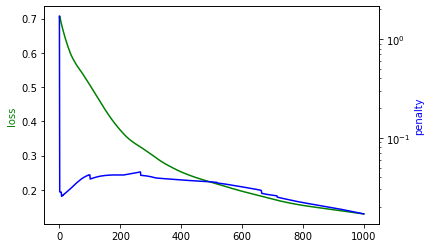

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_, 'g-')
ax2.plot(l_, 'b-')
ax1.set_ylabel('loss', color='g')
ax2.set_yscale('log')
ax2.set_ylabel('penalty', color='b')

---
## Cross-validation
---

In [13]:
# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# A maximum of max_epochs is used for training
max_epochs    = 1000

# Record test labels
r_y_test = np.array([])
# Record predictions
r_y_pred = np.array([])

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X, y=y, groups=y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  trainloader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=X_train.shape[0], shuffle=True, num_workers=1)
  testloader  = DataLoader(TensorDataset(torch.Tensor(X_test ), torch.Tensor(y_test )), batch_size=X_test .shape[0], shuffle=True, num_workers=1)

  model = Model([20], [10])
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  optimizer = lf.Optimizer(optimizer, 1e-8)

  for _epoch in range(0, max_epochs): # 5 epochs at maximum    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      # Get inputs
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      loss.backward()
      # Perform optimization
      optimizer.step()

      #print(f'Loss: {loss.item()}')

    # check if converged
    if optimizer.converged(loss.item()):
      break
  # Process is complete.
  print('Training process has finished.')

  with torch.no_grad():
    # evaluate model
    for i, data in enumerate(testloader, 0):

      inputs, targets = data

      outputs = model(inputs)

      r_y_test = np.append(r_y_test, targets.numpy())
      r_y_pred = np.append(r_y_pred, outputs.flatten().numpy())

Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


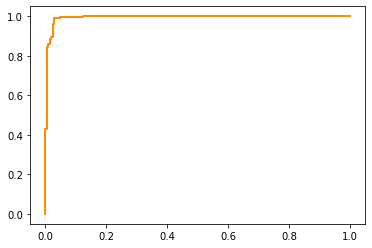

In [14]:
fpr, tpr, _ = metrics.roc_curve(r_y_test,  r_y_pred)
plt.plot(fpr,tpr, lw=2, color="darkorange")